#### Import required libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

#### Load Data

In [5]:
path = '../input/h-and-m-personalized-fashion-recommendations/'
articles = pd.read_csv(path + 'articles.csv')
customers = pd.read_csv(path + 'customers.csv')
transactions = pd.read_csv(path + 'transactions_train.csv')
sample_submission = pd.read_csv(path + 'sample_submission.csv')

In [6]:
tqdm.pandas()

total_folders = total_files = 0
folder_info = []
images_names = []
for base, dirs, files in tqdm(os.walk('/kaggle/input/h-and-m-personalized-fashion-recommendations/')):
    for directories in dirs:
        folder_info.append((directories, len(os.listdir(os.path.join(base, directories)))))
        total_folders += 1
    for _files in files:
        total_files += 1
        if len(_files.split(".jpg"))==2:
            images_names.append(_files.split(".jpg")[0])

88it [01:08,  1.29it/s]


#### Defined Functions

In [7]:
# to get unique values
def unique_values(data):
    
    total_records = data.count()
    unique_df = pd.DataFrame(total_records)
    unique_df.columns = ['total']
    unique_records = []
    
    for column in data.columns:
        unique = data[column].nunique()
        unique_records.append(unique)
        
    unique_df['unique_count'] = unique_records
    
    return unique_df

In [8]:
# plot bar chart
def categorical_counts_bar(data, x=None):
    
    plt.figure(figsize=(12, 8))
    
    # univariate analysis: bar chart
    plt.title(f'Distribution of articles by {x} (Top 25)', fontsize=12, weight='bold')
    
    # calculate value counts for the specified column
    # sort and get top 25 rows
    value_counts = data[x].value_counts().sort_values(ascending=False).head(25)  
    
    # plotting bar chart for the top 25 rows
    sns.barplot(x=value_counts.index, y=value_counts.values, color='seagreen')
    plt.xlabel(x, fontsize=8)
    plt.ylabel('Count', fontsize=8)
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(fontsize=8)
    plt.show()

In [9]:
# plot pie chart
def categorical_counts_pie(data, x=None):
    plt.figure(figsize=(3,3))  # Adjust figure size
    colors=sns.color_palette(['royalblue','seagreen','gold','orange','coral'])
    plt.title(f'Distribution of articles by {x}', fontsize=12, weight='bold')

    # Calculate value counts for the specified column
    value_counts = data[x].value_counts().sort_values(ascending=False)

    # Plotting pie chart
    plt.pie(value_counts, labels=value_counts.index, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.show()

In [10]:
# plot histogram
def plot_histogram(data, y_col, hue_col):
    f, ax = plt.subplots(figsize=(15, 7))
    sns.histplot(data=data, y=y_col, hue=hue_col, multiple="stack", palette='tab10', ax=ax)
    ax.set_xlabel('Count by Garment Group')
    ax.set_ylabel('Garment Group')
    plt.show()

In [11]:
# plot image samples 
def plot_image_samples(imageArticle, product_group_name, cols=1, rows=-1):
    image_path = "/kaggle/input/h-and-m-personalized-fashion-recommendations/images/"
    _df = imageArticle.loc[imageArticle.product_group_name==product_group_name]
    article_ids = _df.article_id.values[0:cols*rows]
    plt.figure(figsize=(2 + 3 * cols, 2 + 4 * rows))
    for i in range(cols * rows):
        article_id = ("0" + str(article_ids[i]))[-10:]
        plt.subplot(rows, cols, i + 1)
        plt.axis('off')
        plt.title(f"{product_group_name} {article_id[:3]}\n{article_id}.jpg")
        image = Image.open(f"{image_path}{article_id[:3]}/{article_id}.jpg")
        plt.imshow(image)

#### Data Exploration and Summary Statistics

In [12]:
articles.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [13]:
articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int64 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null  object
 12  perceived_colour_master_id    105542 non-null  int64 
 13 

In [14]:
articles.describe()

,article_id,product_code,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_group_no,section_no,garment_group_no
count,1.055420e+05,105542.000000,105542.000000,1.055420e+05,105542.000000,105542.000000,105542.000000,105542.000000,105542.000000,105542.000000,105542.000000
mean,6.984246e+08,698424.563378,234.861875,1.009515e+06,32.233822,3.206183,7.807972,4532.777833,3.171534,42.664219,1010.438290
std,1.284624e+08,128462.384432,75.049308,2.241359e+04,28.086154,1.563839,5.376727,2712.692011,4.353234,23.260105,6.731023
min,1.087750e+08,108775.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.000000,1201.000000,1.000000,2.000000,1001.000000
25%,6.169925e+08,616992.500000,252.000000,1.010008e+06,9.000000,2.000000,4.000000,1676.000000,1.000000,20.000000,1005.000000
50%,7.022130e+08,702213.000000,259.000000,1.010016e+06,14.000000,4.000000,5.000000,4222.000000,2.000000,46.000000,1009.000000
75%,7.967030e+08,796703.000000,272.000000,1.010016e+06,52.000000,4.000000,11.000000,7389.000000,4.000000,61.000000,1017.000000
max,9.594610e+08,959461.000000,762.000000,1.010029e+06,93.000000,7.000000,20.000000,9989.000000,26.000000,97.000000,1025.000000


In [15]:
unique_values(articles)

,total,unique_count
article_id,105542,105542
product_code,105542,47224
prod_name,105542,45875
product_type_no,105542,132
product_type_name,105542,131
product_group_name,105542,19
graphical_appearance_no,105542,30
graphical_appearance_name,105542,30
colour_group_code,105542,50
colour_group_name,105542,50


In [16]:
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [17]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   customer_id             1371980 non-null  object 
 1   FN                      476930 non-null   float64
 2   Active                  464404 non-null   float64
 3   club_member_status      1365918 non-null  object 
 4   fashion_news_frequency  1355969 non-null  object 
 5   age                     1356119 non-null  float64
 6   postal_code             1371980 non-null  object 
dtypes: float64(3), object(4)
memory usage: 73.3+ MB


In [18]:
customers.describe()

,FN,Active,age
count,476930.0,464404.0,1.356119e+06
mean,1.0,1.0,3.638696e+01
std,0.0,0.0,1.431363e+01
min,1.0,1.0,1.600000e+01
25%,1.0,1.0,2.400000e+01
50%,1.0,1.0,3.200000e+01
75%,1.0,1.0,4.900000e+01
max,1.0,1.0,9.900000e+01


In [19]:
unique_values(customers)

,total,unique_count
customer_id,1371980,1371980
FN,476930,1
Active,464404,1
club_member_status,1365918,3
fashion_news_frequency,1355969,3
age,1356119,84
postal_code,1371980,352899


In [20]:
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [21]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   t_dat             object 
 1   customer_id       object 
 2   article_id        int64  
 3   price             float64
 4   sales_channel_id  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.2+ GB


In [22]:
transactions.describe()

,article_id,price,sales_channel_id
count,3.178832e+07,3.178832e+07,3.178832e+07
mean,6.962272e+08,2.782927e-02,1.704028e+00
std,1.334480e+08,1.918113e-02,4.564786e-01
min,1.087750e+08,1.694915e-05,1.000000e+00
25%,6.328030e+08,1.581356e-02,1.000000e+00
50%,7.145820e+08,2.540678e-02,2.000000e+00
75%,7.865240e+08,3.388136e-02,2.000000e+00
max,9.562170e+08,5.915254e-01,2.000000e+00


In [23]:
unique_values(transactions)

,total,unique_count
t_dat,31788324,734
customer_id,31788324,1362281
article_id,31788324,104547
price,31788324,9857
sales_channel_id,31788324,2


In [24]:
print(f'Minimum date in transaction dataset: {transactions["t_dat"].min()}')
print(f'Maximum date in transaction dataset: {transactions["t_dat"].max()}')

Minimum date in transaction dataset: 2018-09-20
Maximum date in transaction dataset: 2020-09-22


In [25]:
sample_submission.head()

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0706016001 0706016002 0372860001 0610776002 07...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0706016001 0706016002 0372860001 0610776002 07...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016001 0706016002 0372860001 0610776002 07...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0706016001 0706016002 0372860001 0610776002 07...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0706016001 0706016002 0372860001 0610776002 07...


In [26]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 2 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   customer_id  1371980 non-null  object
 1   prediction   1371980 non-null  object
dtypes: object(2)
memory usage: 20.9+ MB


#### Data Pre-Processing

In [27]:
# handling missing values
articles = articles.drop(columns=['detail_desc'])
customers['FN'] = customers['FN'].fillna(0)
customers['Active'] = customers['Active'].fillna(0)
customers['club_member_status'] = customers['club_member_status'].fillna('INACTIVE')
customers['age'] = customers['age'].fillna(customers['age'].median())

In [28]:
# coverting data types
transactions['sales_channel_id'] = transactions['sales_channel_id'].astype('category')
transactions['t_dat'] = pd.to_datetime(transactions['t_dat'])

In [29]:
# merge data
merged_df = transactions.merge(articles, on='article_id', how='left')
merged_df = merged_df.merge(customers.drop(columns=['postal_code']), on='customer_id', how='left')

merged_df.head()

,t_dat,customer_id,article_id,price,sales_channel_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,...,index_group_name,section_no,section_name,garment_group_no,garment_group_name,FN,Active,club_member_status,fashion_news_frequency,age
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,663713,Atlanta Push Body Harlow,283,Underwear body,Underwear,...,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear",0.0,0.0,ACTIVE,NONE,24.0
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2,541518,Rae Push (Melbourne) 2p,306,Bra,Underwear,...,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear",0.0,0.0,ACTIVE,NONE,24.0
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2,505221,Inca Jumper,252,Sweater,Garment Upper body,...,Divided,58,Divided Selected,1003,Knitwear,1.0,1.0,ACTIVE,Regularly,32.0
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2,685687,W YODA KNIT OL OFFER,252,Sweater,Garment Upper body,...,Ladieswear,15,Womens Everyday Collection,1023,Special Offers,1.0,1.0,ACTIVE,Regularly,32.0
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2,685687,W YODA KNIT OL OFFER,252,Sweater,Garment Upper body,...,Ladieswear,15,Womens Everyday Collection,1023,Special Offers,1.0,1.0,ACTIVE,Regularly,32.0


## Univariate Analysis

#### Articles Dataset

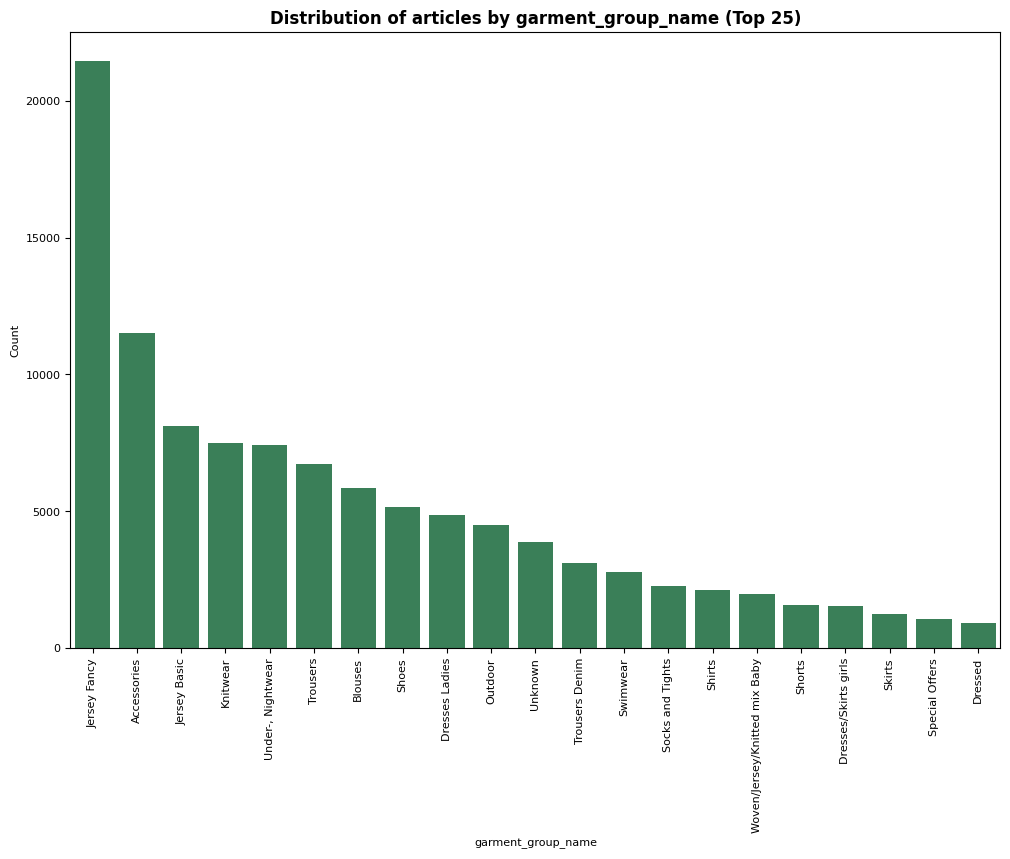

In [30]:
categorical_counts_bar(data=articles, x='garment_group_name')

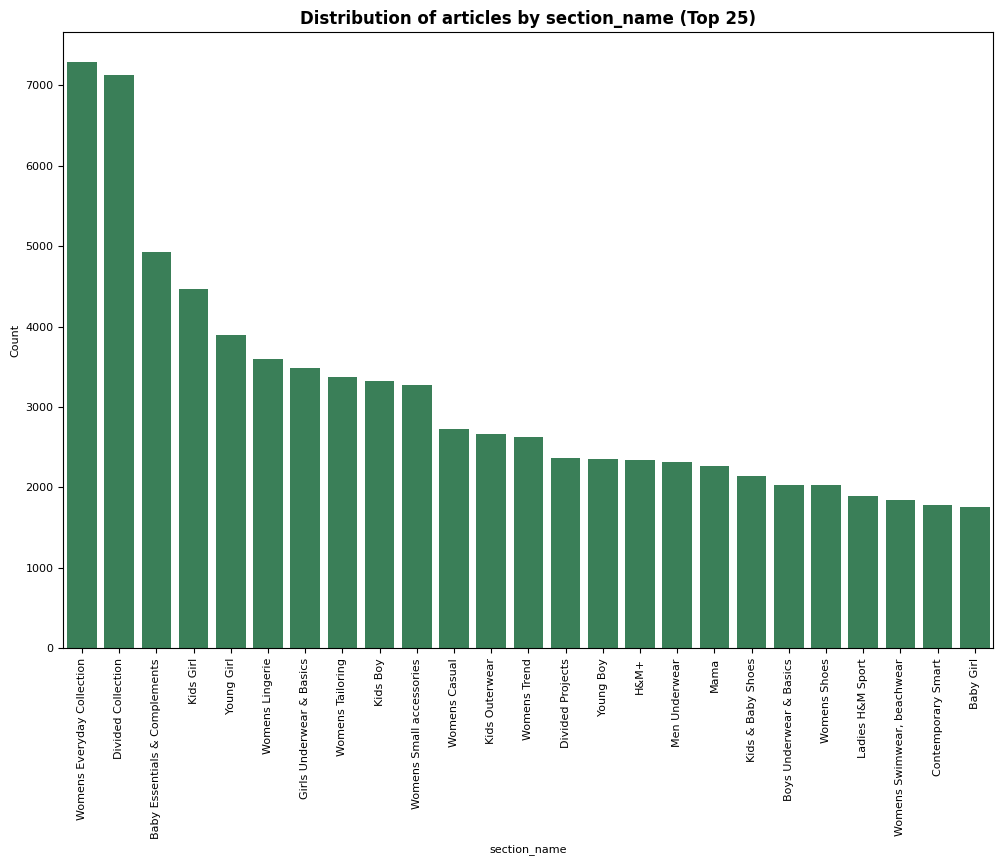

In [31]:
categorical_counts_bar(data=articles, x='section_name')

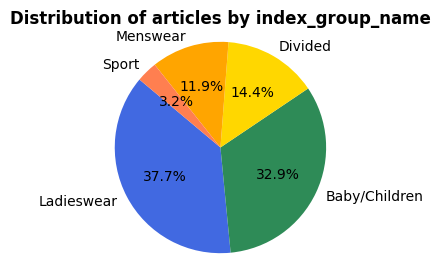

In [32]:
categorical_counts_pie(data=articles, x='index_group_name')

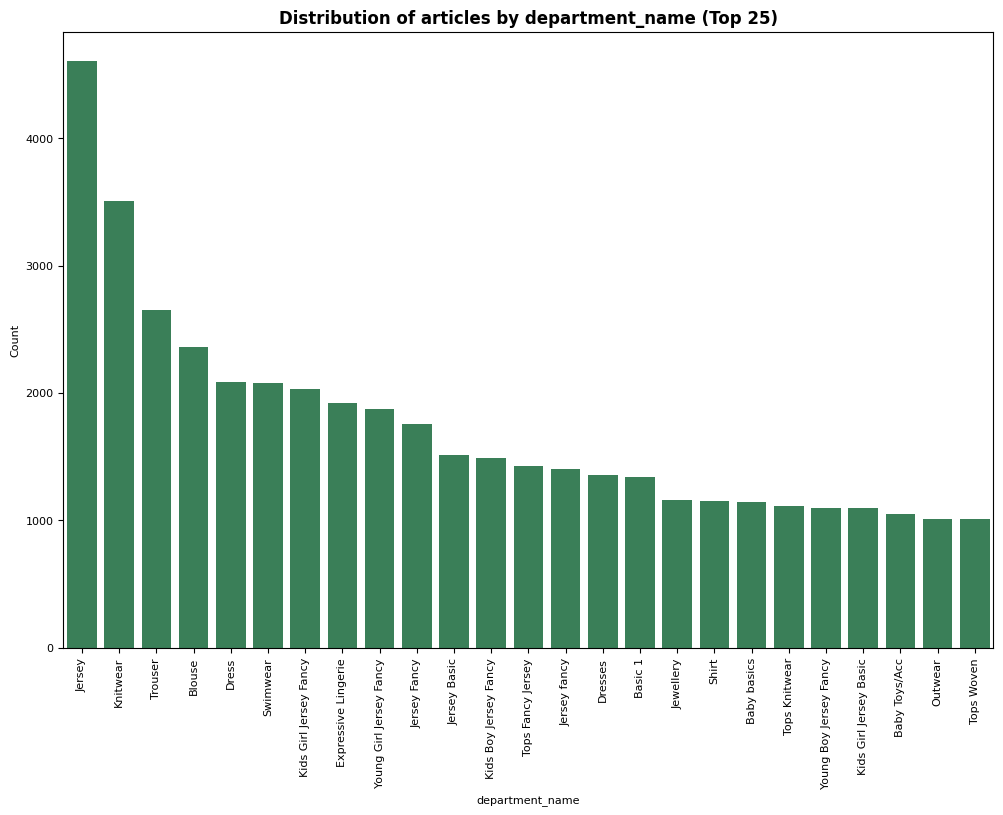

In [33]:
categorical_counts_bar(data=articles, x='department_name')

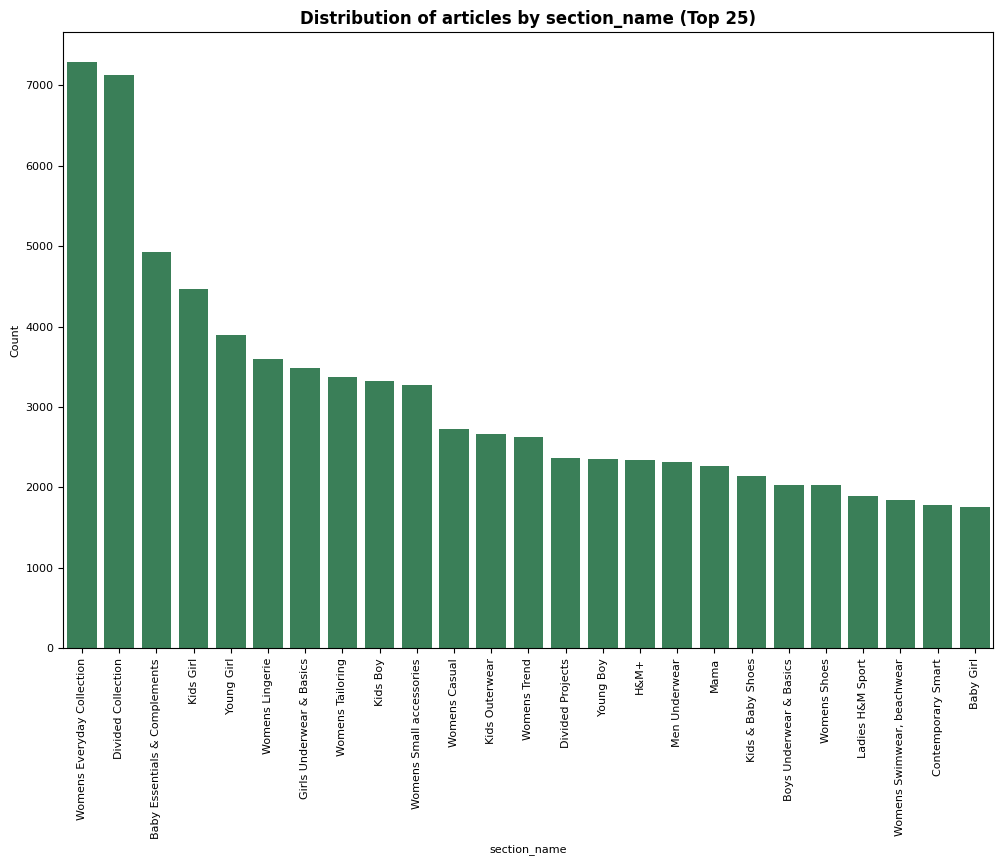

In [34]:
# Example usage for univariate analysis
categorical_counts_bar(data=articles, x='section_name')

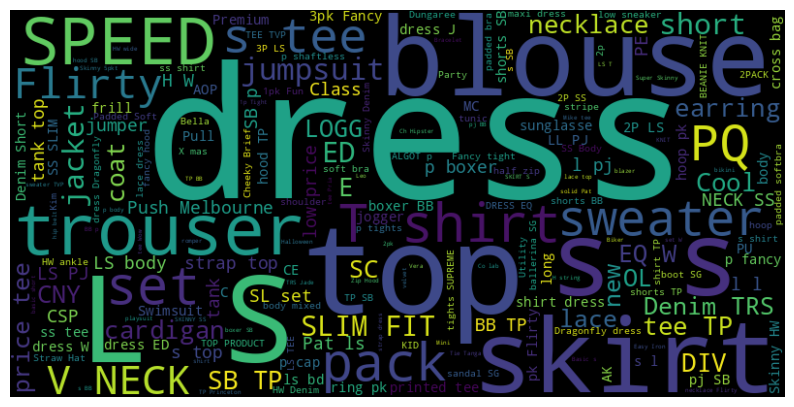

In [35]:
# Text Data (Word Cloud for 'prod_name' or 'detail_desc' if available)
text_data = ' '.join(articles['prod_name'].dropna().astype(str))
wordcloud = WordCloud(width=800, height=400).generate(text_data)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Image dataset

In [36]:
imageData = pd.DataFrame(images_names, columns = ["image_name"])
imageData["article_id"] = imageData["image_name"].apply(lambda x: int(x[1:]))
imageData.head(10)

,image_name,article_id
0,0570177001,570177001
1,0575944002,575944002
2,0576129001,576129001
3,0570806001,570806001
4,0572155001,572155001
5,0576693003,576693003
6,0577759003,577759003
7,0578630014,578630014
8,0577327002,577327002
9,0570579003,570579003


In [37]:
imageArticle = articles[["article_id", "product_code", "product_group_name", "product_type_name"]].merge(imageData, on=["article_id"], how="left")
print(imageArticle.shape)
imageArticle.head()

(105542, 5)


,article_id,product_code,product_group_name,product_type_name,image_name
0,108775015,108775,Garment Upper body,Vest top,0108775015
1,108775044,108775,Garment Upper body,Vest top,0108775044
2,108775051,108775,Garment Upper body,Vest top,0108775051
3,110065001,110065,Underwear,Bra,0110065001
4,110065002,110065,Underwear,Bra,0110065002


In [38]:
article_no_image_df = imageArticle.loc[imageArticle.image_name.isna()]
print(article_no_image_df.shape)
article_no_image_df.head()

(442, 5)


,article_id,product_code,product_group_name,product_type_name,image_name
88,174057028,174057,Nightwear,Pyjama jumpsuit/playsuit,NaN
117,179208001,179208,Garment Lower body,Leggings/Tights,NaN
258,212042043,212042,Shoes,Sneakers,NaN
259,212042066,212042,Shoes,Sneakers,NaN
261,212629004,212629,Garment Full body,Dress,NaN


In [39]:
print("Product codes without images: ", article_no_image_df.product_code.nunique())
print("Product group names without images: ", list(article_no_image_df.product_group_name.unique()))

Product codes without images:  372
Product group names without images:  ['Nightwear', 'Garment Lower body', 'Shoes', 'Garment Full body', 'Accessories', 'Garment Upper body', 'Underwear', 'Socks & Tights', 'Swimwear', 'Cosmetic']


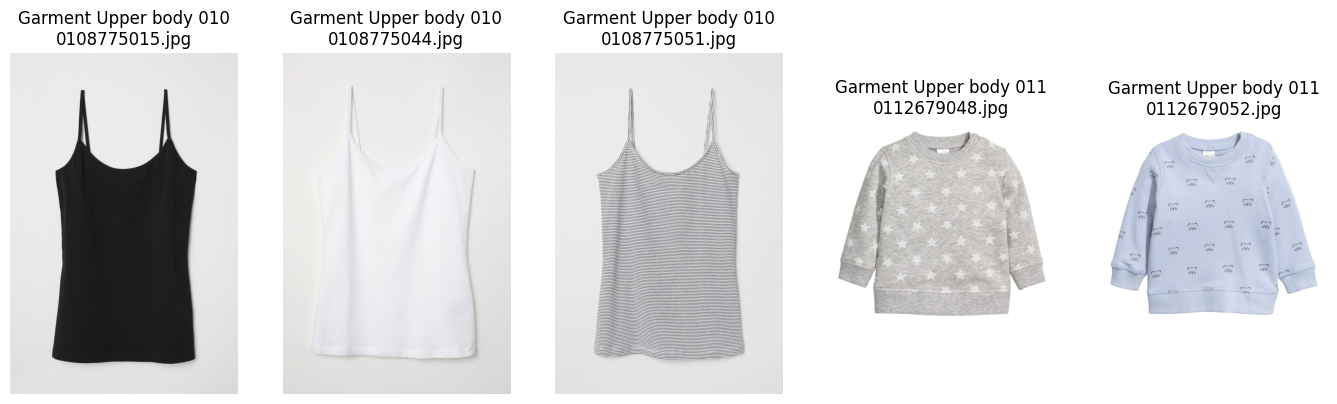

In [40]:
plot_image_samples(imageArticle, "Garment Upper body", 5, 1)

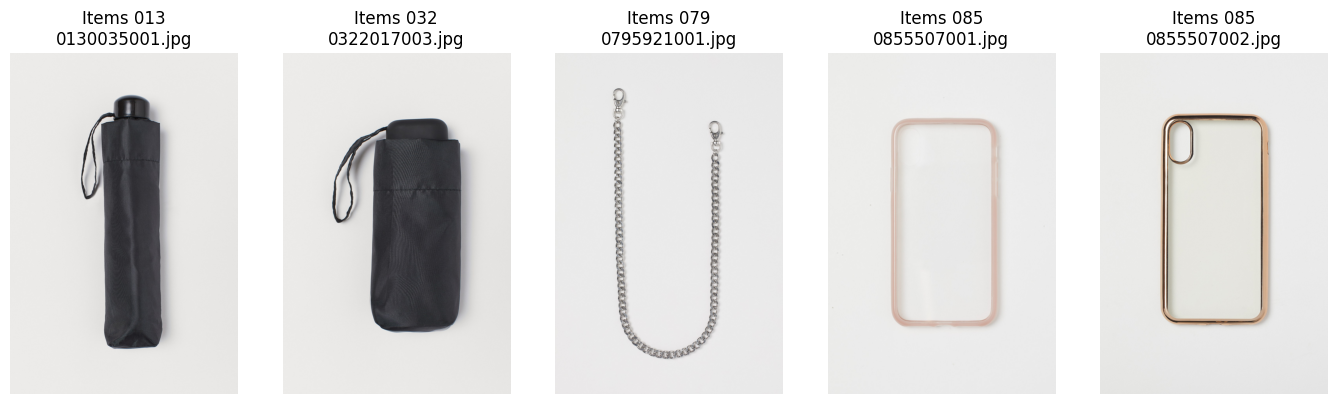

In [41]:
plot_image_samples(imageArticle, "Items", 5, 1)

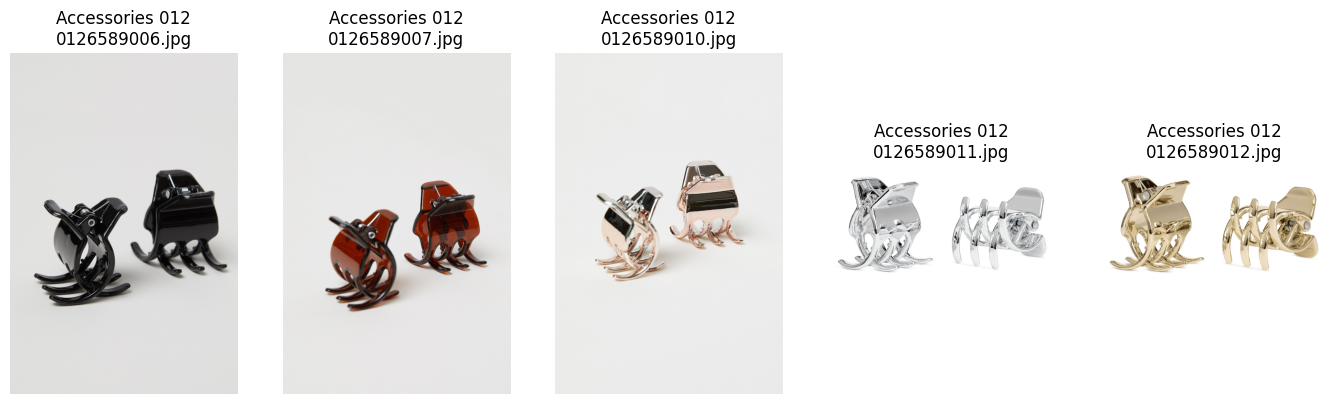

In [42]:
plot_image_samples(imageArticle, "Accessories", 5, 1)